In [1]:
import librosa
import tgt
import torch
from torchaudio.transforms import Resample
import numpy as np
from scipy.io.wavfile import read

from fastspeech2.audio import tools
from fastspeech2.utils import get_alignment
from fastspeech2.hparams import HyperParameters as hp

from matplotlib import pyplot as plt
%matplotlib inline  

/home/s1661552/miniconda3/envs/mlp/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/home/s1661552/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370169888/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
vctk_path = "/home/s1661552/data/datasets/VCTK"
vctk_file_1 = vctk_path + "/wav48/p236/p236_363.wav"
vctk_tg_file_1 = vctk_path + "/preprocessed/TextGrid/p236/p236_363.TextGrid"
vctk_file_2 = vctk_path + "/wav48/p307/p307_363.wav"
vctk_tg_file_2 = vctk_path + "/preprocessed/TextGrid/p307/p307_363.TextGrid"

In [16]:
def process_utterance(wav_file, tg_path):       
    # Get alignments
    textgrid = tgt.io.read_textgrid(tg_path)
    
    phone, duration, start, end = get_alignment(textgrid.get_tier_by_name('phones'))        
    text = '{'+ '}{'.join(phone) + '}' # '{A}{B}{$}{C}', $ represents silent phones
    text = text.replace('{$}', ' ')    # '{A}{B} {C}'
    text = text.replace('}{', ' ')     # '{A B} {C}'
    
    if start >= end:
        return None

    # Read and trim wav files
  
    sr, wav = read(wav_file) 
    wav = torch.FloatTensor(wav.astype(np.float32))
    if sr != hp.sampling_rate:
        wav = Resample(orig_freq=sr, new_freq=hp.sampling_rate)(wav)
        
    # Compute mel-scale spectrogram and energy
    mel_spectrogram, energy = tools.get_mel_from_wav(wav)
    plt.imshow(mel_spectrogram)
    plt.title("Original")
    plt.show()
    
    print("Start: {}, end: {}".format(start, end))
#     print("Waveform max: {}".format(wav.max()))
#     print("Waveform min: {}".format(wav.min()))
#     print("Waveform length: {}".format(len(wav)/sr))

    wav = wav[int(hp.sampling_rate*start):int(hp.sampling_rate*end)]
#     print("Aligned waveform length: {}".format(len(wav)/sr))

    mel_spectrogram, energy = tools.get_mel_from_wav(wav)
    plt.imshow(mel_spectrogram)
    plt.title("Trimmed")
    plt.show()
    
    mel_spectrogram = mel_spectrogram.cpu().numpy().astype(np.float32)[:, :sum(duration)]
    energy = energy.cpu().numpy().astype(np.float32)[:sum(duration)]
    if mel_spectrogram.shape[1] >= hp.max_seq_len:
        return None

In [17]:
import os

def anaylze_wavs():
    vctk_spkers = os.listdir("/home/rokas/year4/mlp/cw3/data/datasets/VCTK/txt")
    vctk_spkers.sort()
    max_val = 0
    for spker in vctk_spkers:
        for txt_file in os.listdir(os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK/txt", spker)):
            with open(os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK", 
                                   'txt', spker, txt_file), encoding='utf-8') as f:

                basename = txt_file.replace(".txt", "")
                wav_path = os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK", 
                                        'wav48', spker, '{}.wav'.format(basename))
                sr, wav = read(wav_path)
                wav = wav.astype(np.float32) 
                orig_max = np.max(np.abs(wav))

                wav = torch.tensor(wav)
                if sr != hp.sampling_rate:
                    wav = Resample(orig_freq=sr, new_freq=hp.sampling_rate)(wav)

                if torch.max(torch.abs(wav)) > max_val:
                    max_val = torch.ceil(torch.max(torch.abs(wav)))
                    print("Resampled: {}, original: {}".format(max_val.item(), orig_max))

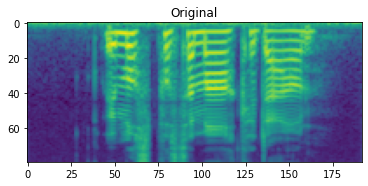

Start: 0.46, end: 1.92


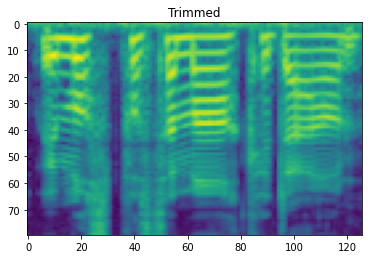

In [18]:
process_utterance(vctk_file_1, vctk_tg_file_1)

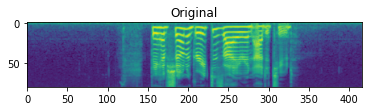

Start: 1.28, end: 3.92


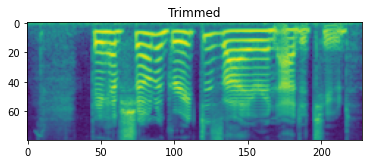

In [19]:
process_utterance(vctk_file_2, vctk_tg_file_2)